# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



### Load all Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import the reference data for parties
party_information = pd.read_csv('partyInformation.csv', header=0)

# Create a color key for parties based on the letter
color_key = party_information[['parti', 'farve']].set_index('parti').to_dict()['farve']
color_key_shorthand = party_information[['bogstav', 'farve']].set_index('bogstav').to_dict()['farve']
# partyInformation

In [3]:
# Reading all the data for candidates and their responses
data = pd.read_excel('alldata.xlsx', header=0)
# data

## Data Cleanup
The data cleanup undergoes the following steps:
- Correction of party names to match the reference table, some parties have longer official names that are not in the reference table.
    - Since most of the data already matches the reference table, we only need to correct the few that don't.
- Verification of duplicate candidate names.
- Removal of candidates where their age is set to 0.
    - This is obviously nonsensical and likely a placeholder for missing data, so we remove these candidates for simplicity. 


In [4]:
# Data Cleanup
# Correct party names to match the reference table, as a function for reusability
alternative_pary_names = {
    'Frie Grønne, Danmarks Nye Venstrefløjsparti': 'Frie Grønne',
    'Det Konservative Folkeparti': 'Konservative',
}
data['parti'] = data['parti'].replace(alternative_pary_names)

# Verify duplicate candidates
if data['navn'].duplicated().sum() > 0:
    print("Duplicate candidate names detected.")
else:
    print("No duplicate candidate names detected.")

data = data[data['alder'] > 0]

No duplicate candidate names detected.


In [5]:
# To sort all future charts by party, we can create a plot order based on the letters assigned to each party, UFG is removed and added at the end for unaligned candidates to show up last
plot_order = party_information['bogstav']
plot_order = plot_order[plot_order != 'UFG']
plot_order = plot_order.sort_values(ascending=True)
plot_order = pd.concat([plot_order, pd.Series('UFG')], ignore_index=True)
plot_order = plot_order.to_frame('bogstav').merge(party_information[['parti', 'bogstav']], on='bogstav', how='left')
# plot_order

# TODO: Are we actually using this?
alignment_order = {
    'Far-left': -3,
    'Left-wing': -2,
    'Centre-left': -1,
    'Non-Aligned': 0,
    'Centre-right': 1,
    'Right-wing': 2,
    'Far-right': 3
}

In [6]:
# Separate question data from the traits (name, age, parti)
question_data = data.drop(columns=['navn', 'parti', 'storkreds', 'alder'])
candidate_data = data.drop(columns=question_data.columns)

## Translating the questions
Using the translated question keys from the example provided by our teacher, we can translate the questions into English for easier readability.

In [7]:
translated_questions = pd.Series({
    '530': 'Denmark should spend more money on strengthening train and bus services rather than building new motorways',
    '531': 'A special tax should be introduced on the very highest incomes',
    '533': 'Crime committed in vulnerable housing areas should be punished particularly severely',
    '534': 'In the long term, Denmark should leave the EU',
    '535': 'It is sensible that Denmark will spend significantly more money on defense in the coming years',
    '537': 'It is okay for economic inequality to increase as long as Danes generally become richer',
    '538': 'Parents\' income should be one of the criteria for distributing students in high schools',
    '540': 'It should be possible to make a profit from running private kindergartens and nurseries',
    '541': 'Tax should be introduced on profits from home sales',
    '543': 'It is a good idea that the unemployment benefit rate for new graduates has been reduced',
    '544': 'Transgender people under 18 should have the option for legal gender change (changing CPR number)',
    '545': 'The retirement age should continue to rise in line with increasing life expectancy',
    '546': 'Denmark should investigate the possibility of developing nuclear power as an energy source domestically',
    '547': 'A government should be formed across the center',
    '548': 'Money should be allocated to help social benefit recipients when prices rise',
    '550': 'Quotas should be introduced ensuring at least 30 percent women on company boards',
    '551': 'There should be permanent border control between Denmark and Germany',
    '552': 'One should automatically become an organ donor at 18 unless actively opting out',
    '553': 'More education places should be relocated from the big cities',
    '555': 'Asylum seekers should be sent to a country outside the EU - e.g., Rwanda - while their application is processed',
    '556': 'The so-called Arne pension should be abolished',
    '557': 'Wages for employees in classic welfare professions like nurses and educators should be significantly increased',
    '559': 'Denmark should introduce CO2 tax on air travel',
    '561': 'It is a good idea to have nature national parks where large animals are released to live wild',
    '563': 'Young people up to 24 years should have the right to free public psychological help without doctor referral',
    
    # Bornholm specific questions
    'bornholm-1': 'The state should ensure sufficient doctors, nurses, dentists, chiropractors and other healthcare professionals on Bornholm through particularly attractive conditions',
    'bornholm-2': 'The state should ensure that air traffic to and from Bornholm gets status as socially conditioned route and possibility for operational subsidies on par with ferry traffic',
    'bornholm-3': 'More money should be allocated to Defense presence on water, land and in the air on Bornholm',
    'bornholm-4': 'It should be easier to bring in foreign labor to Bornholm',
    'bornholm-5': 'The decision to establish a nature national park on a piece of Almindingen with fenced areas with large animals should be reversed',
    
    # Funen specific questions
    'fyns-1': 'Police should be given more money to combat gang crime in vulnerable housing areas',
    'fyns-2': 'It should be free to cross the Great Belt Bridge at the expense of funding other state infrastructure projects',
    'fyns-3': 'Langeland Municipality should merge with Svendborg Municipality to address economic problems',
    'fyns-4': 'The state should ensure cheaper ferries between Danish islands year-round at the expense of expanding other traffic projects like motorways and railways',
    'fyns-5': 'Even more higher education places should be moved from Odense to other Funen cities',
    
    # Copenhagen outskirts specific questions
    'københavns omegns-1': 'It is more important to invest in sustainable transport like public transit and cycling than expanding motorways such as Hillerød motorway, Frederikssund motorway and Motor Ring 3 and 4',
    'københavns omegns-2': 'Less money should be sent from East to West Denmark in municipal equalization',
    'københavns omegns-3': 'There should be stricter environmental requirements for industry and agriculture near nature areas like streams and lakes to prevent pollution discharge, even if requirements mean extra costs for businesses',
    'københavns omegns-4': 'To reduce congestion, air pollution and CO₂ emissions, road pricing should be introduced so motorists are taxed for driving in Copenhagen and surrounding municipalities Hvidovre, Rødovre, Herlev, Gladsaxe and Gentofte',
    'københavns omegns-5': 'To get more people in the capital to choose bikes over cars, a special travel deduction should be introduced for cyclists so commuters cycling six kilometers or more to work can get a tax deduction',
    
    # Copenhagen specific questions
    'københavns-1': 'Overall it was the right decision to move state workplaces and education outside the capital',
    'københavns-2': 'To reduce congestion, air pollution and CO₂ emissions, road pricing should be introduced so motorists are taxed for driving in Copenhagen',
    'københavns-3': 'Copenhagen should become a trial city for cannabis legalization where state-owned and operated shops can sell cannabis to citizens over 18',
    'københavns-4': 'The artificial peninsula Lynetteholm is a good project',
    'københavns-5': 'The possibility to demolish public housing, sell public housing to private owners or forcibly relocate residents, as for example in Mjølnerparken and Tingbjerg, should be abolished, partly because there is a shortage of affordable housing in Copenhagen',
    
    # North Jutland specific questions 
    'nordjyllands-1': 'It should be easier to get housing loans in sparsely populated areas through state guarantee for part of the home loan',
    'nordjyllands-2': 'Parliament should expand the number of fenced nature national parks in North Jutland where wild horses, cattle and bison are released',
    'nordjyllands-3': 'A third Limfjord connection should be built over Egholm island - even if it potentially affects environment and wildlife on Egholm',
    'nordjyllands-4': 'Study places should be moved from Denmark\'s four largest cities so higher education is spread across the country',
    'nordjyllands-5': 'North Jutland should host new giant wind turbines up to 450 meters as part of a new national test center',
    
    # North Zealand specific questions
    'nordsjællands-1': 'Less money should be sent from East to West Denmark in municipal equalization',
    'nordsjællands-2': 'It is more important to invest in sustainable transport like public transit and cycling than expanding motorways like Hillerød motorway and Frederikssund motorway',
    'nordsjællands-3': 'It is good that Gribskov along with Hellebæk Forest and Teglstrup Hegn will be converted to nature national parks, even though it means the areas will be fenced',
    'nordsjællands-4': 'There should be stricter environmental requirements for industry and agriculture near nature areas like streams and lakes to prevent pollution discharge, even if requirements mean extra costs for businesses',
    'nordsjællands-5': 'More should be done to reduce traffic noise for residents along state roads in North Zealand. The state should finance this more than previously, even if at the expense of other infrastructure projects',
    
    # Zealand specific questions
    'sjællands-1': 'Over 45,000 citizens in Zealand region don\'t have their own permanent family doctor. The state should earmark money for general practitioners instead of spending on building new local hospitals and large central hospitals',
    'sjællands-2': 'It should be made easier to set up wind turbines and solar cells on land - as we saw at Kriegers Flak off Møn where lengthy case processing and complaints from neighbors and nature organizations unnecessarily delay projects',
    'sjællands-3': 'At an old fire school in Korsør, pollution with toxic PFOS/PFAS substances has affected a large local group, and up to 15,000 plots in Denmark are estimated contaminated with these substances. The government/Parliament should allocate more money to clean the contaminated sites',
    'sjællands-4': 'A fixed connection across Kattegat should be abandoned. It\'s too expensive and the wrong choice climate-wise',
    'sjællands-5': 'It\'s a good idea that the government has decided to spend about a billion kroner on a gas pipeline from Everdrup in South Zealand to Lolland and Falster. This means among other things that Nordic Sugar\'s factories in Nakskov and Nykøbing F., which are major energy consumers, can switch from oil and coal to natural gas - and later biogas',
    
    # South Jutland specific questions
    'sydjyllands-1': 'It is acceptable to forcibly relocate residents in housing areas like Stengårdsvej in Esbjerg, Nørager/Søstjernevej and others in Sønderborg, Sundparken in Horsens and Skovvejen/Skovparken in Kolding to combat parallel societies and crime',
    'sydjyllands-2': 'The temporary border control at the Danish-German border should stop when the current period expires in November',
    'sydjyllands-3': 'Students should get higher student grants (SU) for choosing higher education in cities like Esbjerg, Vejle, Sønderborg, Haderslev and Kolding rather than in the country\'s four largest cities',
    'sydjyllands-4': 'A bridge should be built from Als to Funen',
    'sydjyllands-5': 'The state should ensure more attractive working conditions and higher wages for doctors who settle in outlying areas in South and Southern Jutland, so doctor shortages in certain areas of the region can be addressed',
    
    # West Jutland specific questions
    'vestjyllands-1': 'Although there were many jobs in mink farming in Central and West Jutland, it is better that mink farming is banned once and for all',
    'vestjyllands-2': 'The state should ensure healthcare personnel in municipalities where it is difficult to attract doctors and other healthcare staff',
    'vestjyllands-3': 'Citizens in municipalities where it is windiest must accept that this is also where most wind turbines are installed',
    'vestjyllands-4': 'Car taxes should be changed to make driving cheaper in rural areas with poor access to public transport',
    'vestjyllands-5': 'It is better to invest more in green transition than investing in roads such as the Army Road motorway, the main road between Skive and Herning and a 2+1 road between Herning and Ringkøbing',
    
    # East Jutland specific questions
    'østjyllands-1': 'More untouched nature national parks should be established in East Jutland with wild large animals like horses and cattle',
    'østjyllands-2': 'A Kattegat bridge should be built over Samsø',
    'østjyllands-3': 'It should be easier for municipalities to give permission for solar cells and wind turbines, even though it is often met with criticism from local populations',
    'østjyllands-4': 'More higher education programs in Aarhus should be moved to other smaller provincial towns for example Randers or Horsens',
    'østjyllands-5': 'Motorway E45 should be expanded to six lanes on the stretch between Aarhus North and Randers',
    
    # Additional numbered questions
    '1a': 'Beef should be subject to a climate tax, making half a kilo of minced beef ten kroner more expensive',
    '1b': 'The companies that emit the most CO₂ should pay more in taxes - even if it might cost Danish jobs',
    '2a': 'Parliament should allocate funds targeted at improving wages and working conditions among selected staff groups in the healthcare sector',
    '2b': 'Cigarettes should be subject to an extra tax of 20 kroner per pack',
    '3a': 'Denmark should spend two percent of GDP on defense before 2033 begins',
    '3b': 'Development aid should be increased',
    '4a': 'Economic inequality in Danish society should be reduced',
    '4b': 'The state should do more to compensate Danes for the rising prices that inflation has caused',
    '5a': 'It is necessary to introduce user payment in elderly care to ensure there is enough money for the increasing number of elderly',
    '5b': 'Additional resources should be allocated to elderly care, even if this means other welfare areas get fewer resources',
    '6a': 'Danish immigration policy is too strict',
    '6b': 'It would be a good idea to establish a Danish asylum reception center in Rwanda',
    '7a': 'Introduction of nuclear power in Denmark would be a good contribution to the green transition',
    '7b': 'Denmark should become totally independent of Russian gas and oil as soon as possible, even if it means increased use of coal which is more harmful to the climate',
    '8a': 'Significantly more resources should be allocated to mentally vulnerable young people, even if this means other welfare areas get fewer resources',
    '8b': 'Additional resources should be allocated to caring for the youngest children, even if this means other welfare areas get fewer resources',
    '9a': 'Parts of the student grant (SU) for higher education should be converted to loans to secure resources for other parts of the education sector',
    '9b': 'Schools should do more to help particularly challenged children, even if it will be at the expense of help for other students',
    '10a': 'The public sector currently spends too much money helping people who could manage on their own, and too little money on people who really need help',
    '10b': 'The so-called Arne pension, which allows earlier retirement, should be maintained even though there is a shortage of labor',
    '11a': 'There has been too much focus on Mette Frederiksen\'s handling of the Mink case - under the circumstances she did the right thing',
    '11b': 'It should be investigated whether Mette Frederiksen can be brought before the State Court as a consequence of her handling of the Mink case',
    '12a': 'If corona infection rises significantly in winter, society should be kept as open as possible, even if it could cost lives',
    '12b': 'If corona infection rises significantly in winter, regular tests should be required for unvaccinated people in Denmark'
})

translated_data = question_data.rename(columns=translated_questions)
question_relevance = translated_data.describe().T.sort_values('std', ascending=False)
question_relevance

,count,mean,std,min,25%,50%,75%,max
"Asylum seekers should be sent to a country outside the EU - e.g., Rwanda - while their application is processed",851.0,-0.179788,1.656890,-2.0,-2.0,-1.0,1.0,2.0
The so-called Arne pension should be abolished,851.0,-0.371328,1.644478,-2.0,-2.0,-1.0,1.0,2.0
Denmark should investigate the possibility of developing nuclear power as an energy source domestically,851.0,0.077556,1.621503,-2.0,-2.0,1.0,2.0,2.0
"The so-called Arne pension, which allows earlier retirement, should be maintained even though there is a shortage of labor",851.0,0.368978,1.613962,-2.0,-1.0,1.0,2.0,2.0
A special tax should be introduced on the very highest incomes,851.0,-0.303173,1.613101,-2.0,-2.0,-1.0,1.0,2.0
Transgender people under 18 should have the option for legal gender change (changing CPR number),851.0,-0.175088,1.604740,-2.0,-2.0,-1.0,1.0,2.0
It would be a good idea to establish a Danish asylum reception center in Rwanda,851.0,-0.254994,1.604283,-2.0,-2.0,0.0,1.0,2.0
Danish immigration policy is too strict,851.0,0.015276,1.603233,-2.0,-2.0,0.0,2.0,2.0
It should be investigated whether Mette Frederiksen can be brought before the State Court as a consequence of her handling of the Mink case,851.0,0.591069,1.601357,-2.0,-1.0,1.0,2.0,2.0
Quotas should be introduced ensuring at least 30 percent women on company boards,851.0,-0.361927,1.585421,-2.0,-2.0,-1.0,1.0,2.0


## Average party positions by question

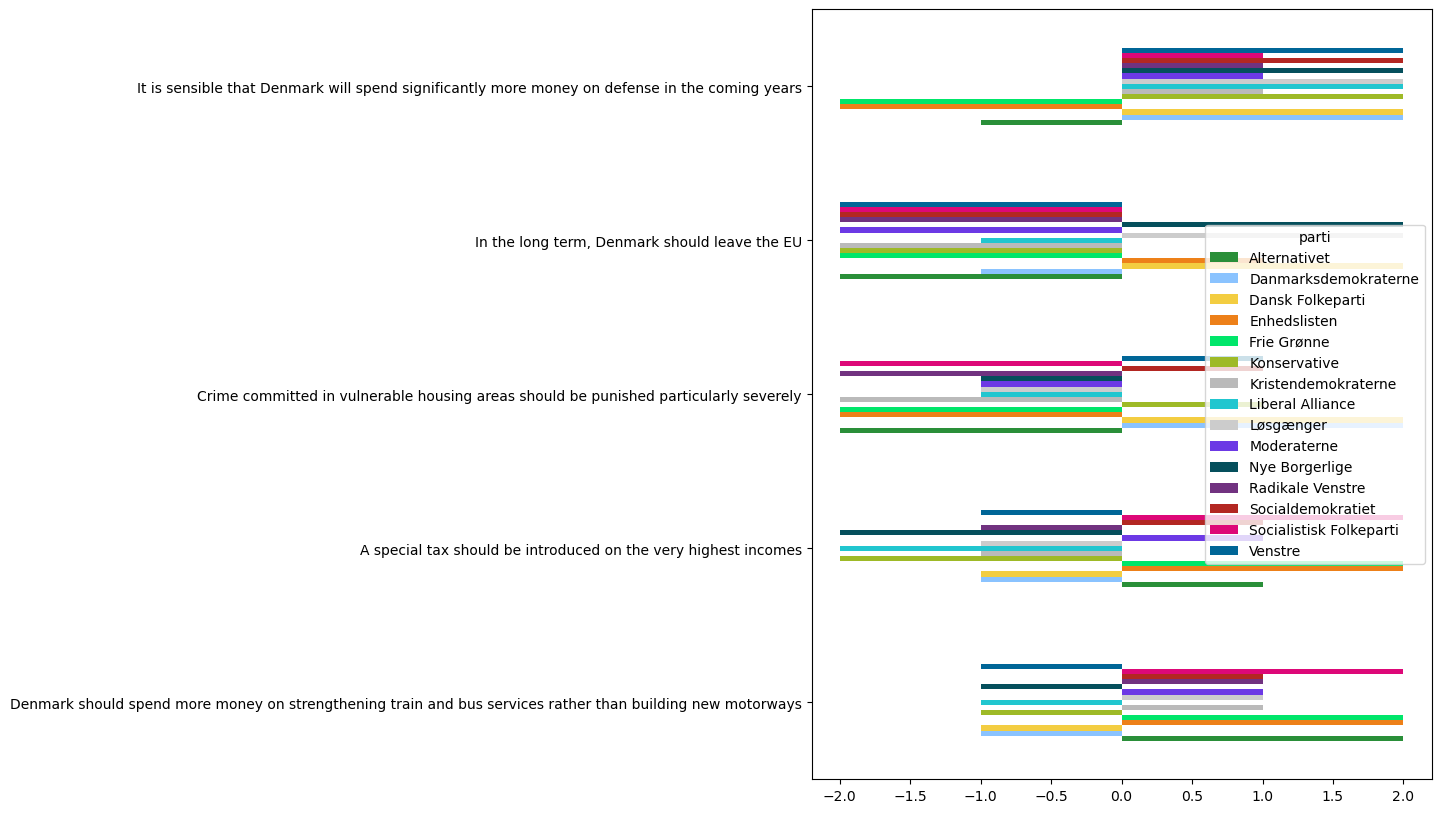

In [33]:
# ('line', 'bar', 'barh', 'kde', 'density', 'area', 'hist', 'box', 'pie', 'scatter', 'hexbin')
party_data = translated_data.groupby(candidate_data['parti']).median().T.iloc[:5].plot(kind='barh', figsize=(8, 10), color=color_key)